In [1]:
import os
import torchvision
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import torch, torchvision
from shutil import copyfile
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms as t
from torch.utils.data import DataLoader
from timeit import default_timer as timer

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to 'drive/a'
os.chdir('/content/drive/MyDrive/christmas_clf')

# Verify the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)
from utils import create_dataset, train, test_one_epoch

Mounted at /content/drive
Current Working Directory: /content/drive/MyDrive/christmas_clf


In [3]:
# config
DIR = "dataset"
ODIR = "original_data"
FOLDERS = ['train', 'test', 'val']
TRAIN_SIZE, TEST_SIZE, VAL_SIZE = 0.7, 0.15, 0.15
BATCH_SIZE = 44
IMAGE_SIZE = 224
SEED = 42
LR = 0.001
EPOCHS = 35
ReduceLROnPlateau_PATIENCE = 5
EARLY_PATIENCE = ReduceLROnPlateau_PATIENCE + 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class_names = create_dataset(ODIR, DIR, TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
transfomer = t.Compose([
    t.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    t.ToTensor()
])
train_transformer = t.Compose([
    t.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    t.RandomHorizontalFlip(p=1),
    t.Pad(padding=30),
    t.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    t.ToTensor(),
])

In [6]:
train_images = datasets.ImageFolder(root=os.path.join(DIR, "train"), transform=transfomer)
train_images += datasets.ImageFolder(root=os.path.join(DIR, "train"), transform=train_transformer)
val_images = datasets.ImageFolder(root=os.path.join(DIR, "val"), transform=transfomer)
test_images = datasets.ImageFolder(root=os.path.join(DIR, "test"), transform=transfomer)

train_dataloader = DataLoader(train_images, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_images, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_images, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(53, 6, 6)

In [11]:
class_names = val_images.classes
sample_batch = next(iter(train_dataloader))
sample_batch[0].shape, sample_batch[1]

(torch.Size([44, 3, 224, 224]),
 tensor([4, 0, 1, 3, 1, 3, 4, 3, 3, 0, 2, 3, 3, 2, 1, 1, 3, 1, 3, 4, 4, 2, 0, 4,
         0, 1, 1, 2, 2, 2, 0, 4, 2, 3, 1, 2, 1, 0, 4, 2, 0, 1, 2, 4]))

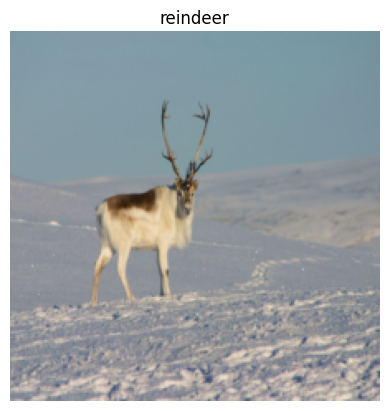

In [ ]:
idx = 14
plt.imshow(sample_batch[0][idx].permute(1,2,0))
plt.title(class_names[sample_batch[1][idx]])
plt.axis(False);

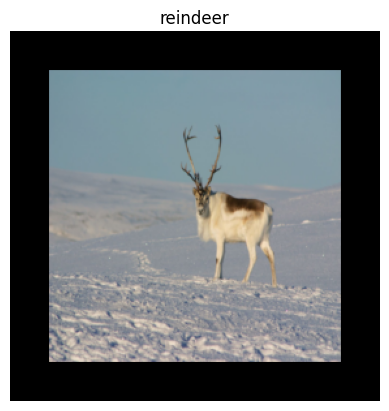

In [ ]:
plt.imshow(t.RandomHorizontalFlip(p=1)(t.Pad(30)(sample_batch[0][idx])).permute(1, 2, 0))
plt.title(class_names[sample_batch[1][idx]])
plt.axis(False);

In [8]:
# model experimental
from itertools import product

params = {
    'filter1': [4, 8, 12],
    'filter2': [4, 8, 12],
    'kernel1': [3, 5],
    'kernel2': [3, 5]
}

all_combinations = list(product(params["filter1"], params["filter2"], params["kernel1"], params["kernel2"]))
all_combinations

[(4, 4, 3, 3),
 (4, 4, 3, 5),
 (4, 4, 5, 3),
 (4, 4, 5, 5),
 (4, 8, 3, 3),
 (4, 8, 3, 5),
 (4, 8, 5, 3),
 (4, 8, 5, 5),
 (4, 12, 3, 3),
 (4, 12, 3, 5),
 (4, 12, 5, 3),
 (4, 12, 5, 5),
 (8, 4, 3, 3),
 (8, 4, 3, 5),
 (8, 4, 5, 3),
 (8, 4, 5, 5),
 (8, 8, 3, 3),
 (8, 8, 3, 5),
 (8, 8, 5, 3),
 (8, 8, 5, 5),
 (8, 12, 3, 3),
 (8, 12, 3, 5),
 (8, 12, 5, 3),
 (8, 12, 5, 5),
 (12, 4, 3, 3),
 (12, 4, 3, 5),
 (12, 4, 5, 3),
 (12, 4, 5, 5),
 (12, 8, 3, 3),
 (12, 8, 3, 5),
 (12, 8, 5, 3),
 (12, 8, 5, 5),
 (12, 12, 3, 3),
 (12, 12, 3, 5),
 (12, 12, 5, 3),
 (12, 12, 5, 5)]

In [9]:
def get_flatten_num(f1, f2, k1, k2) :
    class GetFlattenNum(nn.Module):
        def __init__(self, num_classes=5):
            super(GetFlattenNum, self).__init__()
            self.conv1 = nn.Conv2d(3, f1, kernel_size=k1, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(f1, f2, kernel_size=k2, stride=1, padding=1)
            self.fc1 = nn.Linear(0, num_classes)

        def forward(self, x):
            x = self.conv1(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            return x

    test = GetFlattenNum()
    try :
        test(sample_batch[0])
    except Exception as e :
        flatten_num = int(str(e).split("(")[1].split("x")[1].split(" ")[0])
    return flatten_num

In [12]:
flatten_num = get_flatten_num(4, 4, 3, 3)
class SimpleCNN(nn.Module):
    def __init__(self, f1, f2, k1, k2, flatten_num, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, f1, kernel_size=k1, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=k2, stride=1, padding=1)
        self.fc1 = nn.Linear(flatten_num, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

test = SimpleCNN(4, 4, 3, 3, flatten_num, num_classes=len(class_names))
test(sample_batch[0])[:10]

tensor([[ 0.0543,  0.1245,  0.1209, -0.0485,  0.0837],
        [ 0.0520,  0.1660,  0.0254, -0.0489,  0.1038],
        [ 0.1912,  0.1718,  0.0690, -0.1109,  0.2082],
        [ 0.1735,  0.2094,  0.0249,  0.0117, -0.0224],
        [ 0.1509,  0.1735,  0.0790, -0.0332,  0.1108],
        [ 0.2853,  0.1464, -0.0079, -0.1418,  0.1276],
        [ 0.1450,  0.1229,  0.0688, -0.1428,  0.1016],
        [ 0.1665,  0.1749,  0.0806, -0.0474,  0.0271],
        [ 0.0277,  0.1252,  0.1304, -0.2021,  0.0331],
        [ 0.0831,  0.1408,  0.1253, -0.0789,  0.1536]],
       grad_fn=<SliceBackward0>)

In [ ]:
# experimentals
model_results = pd.DataFrame({"model_name": [], "train_acc": [], "train_loss": [], "val_acc": [], "val_loss": [], "time(min)": []})
for (f1, f2, k1, k2) in all_combinations :
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    model_name = f"clf_f{f1}{f2}_k{k1}{k2}"
    flatten_num = get_flatten_num(f1, f2, k1, k2)
    model_clf = SimpleCNN(f1, f2, k1, k2, flatten_num, num_classes=len(class_names)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_clf.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=ReduceLROnPlateau_PATIENCE, factor=0.9, verbose=True)
    model_result, time = train(
        model_clf, train_dataloader, val_dataloader, loss_fn, optimizer, EPOCHS, scheduler, model_name, class_names, EARLY_PATIENCE
    )

    res = pd.DataFrame(model_result)
    min_loss = res["val_loss"].argmin()
    df = pd.DataFrame(res.iloc[min_loss]).T
    df["model_name"] = model_name
    df["time(min)"] = time
    model_results = pd.concat([model_results, df], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



	start training clf_f1212_k33(MultiClassifier)
EPOCHS 1/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k33 with validation loss = 1.029568

        	train_acc 46.74% | val_acc 62.58%
        	train_loss 1.3787 | val_loss 1.0296
        	Early stopping: 0/8
        
EPOCHS 2/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k33 with validation loss = 0.979958

        	train_acc 67.31% | val_acc 56.55%
        	train_loss 0.9077 | val_loss 0.9800
        	Early stopping: 0/8
        
EPOCHS 3/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k33 w

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



	start training clf_f1212_k35(MultiClassifier)
EPOCHS 1/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k35 with validation loss = 1.442105

        	train_acc 27.34% | val_acc 31.82%
        	train_loss 1.5377 | val_loss 1.4421
        	Early stopping: 0/8
        
EPOCHS 2/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k35 with validation loss = 1.264403

        	train_acc 47.02% | val_acc 45.29%
        	train_loss 1.2455 | val_loss 1.2644
        	Early stopping: 0/8
        
EPOCHS 3/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k35 w

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



	start training clf_f1212_k53(MultiClassifier)
EPOCHS 1/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k53 with validation loss = 1.215152

        	train_acc 37.21% | val_acc 51.03%
        	train_loss 1.4754 | val_loss 1.2152
        	Early stopping: 0/8
        
EPOCHS 2/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k53 with validation loss = 1.002542

        	train_acc 59.28% | val_acc 62.67%
        	train_loss 1.0549 | val_loss 1.0025
        	Early stopping: 0/8
        
EPOCHS 3/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k53 w

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



	start training clf_f1212_k55(MultiClassifier)
EPOCHS 1/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k55 with validation loss = 1.330774

        	train_acc 35.72% | val_acc 45.53%
        	train_loss 1.4921 | val_loss 1.3308
        	Early stopping: 0/8
        
EPOCHS 2/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

	save clf_f1212_k55 with validation loss = 1.244959

        	train_acc 50.84% | val_acc 49.79%
        	train_loss 1.2729 | val_loss 1.2450
        	Early stopping: 0/8
        
EPOCHS 3/35
 1/53 batches
 5/53 batches
 10/53 batches
 15/53 batches
 20/53 batches
 25/53 batches
 30/53 batches
 35/53 batches
 40/53 batches
 45/53 batches
 50/53 batches
 53/53 batches

        	train_acc 55

In [19]:
import pandas as pd
from timeit import default_timer as timer

In [22]:
# evaluate
model_results = {"model_name": [], "test_acc": [], "test_loss": [], "time(sec)": []}
for (f1, f2, k1, k2) in all_combinations :
  model_name = f"clf_f{f1}{f2}_k{k1}{k2}"
  weight_path = f"save_weights/best_clf_f{f1}{f2}_k{k1}{k2}_weights.pt"
  try :
    flatten_num = get_flatten_num(f1, f2, k1, k2)
    loss_fn = nn.CrossEntropyLoss()
    model = SimpleCNN(f1, f2, k1, k2, flatten_num, num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load(weight_path, map_location=device))

    #eval
    print("\n",model_name)
    start_time = timer()
    test_acc, test_loss = test_one_epoch(model, test_dataloader, loss_fn)
    end_time = timer()
    total_time = end_time-start_time
    print("acc :", test_acc, "loss :", test_loss, "time: ",total_time)

    model_results["model_name"].append(model_name)
    model_results["test_acc"].append(test_acc)
    model_results["test_loss"].append(test_loss)
    model_results["time(sec)"].append(total_time)
  except Exception as e:
    pass


 clf_f44_k33
acc : 0.6475044563279858 loss : 1.057015190521876 time:  6.068325187000028

 clf_f44_k35
acc : 0.6045008912655971 loss : 1.0934107700983684 time:  4.04484770199997

 clf_f44_k53
acc : 0.5842245989304812 loss : 1.1145818928877513 time:  4.142472766000083

 clf_f44_k55
acc : 0.5697415329768272 loss : 1.0946129659811656 time:  5.134652876000018

 clf_f48_k33
acc : 0.7118983957219251 loss : 0.9300871938467026 time:  4.519957722999834

 clf_f48_k35
acc : 0.6673351158645277 loss : 0.9173355599244436 time:  3.9861924179999733

 clf_f48_k53
acc : 0.6949643493761141 loss : 0.8913087944189707 time:  4.636918215999913

 clf_f48_k55
acc : 0.6403743315508021 loss : 0.9530016879240671 time:  5.181887483999844

 clf_f412_k33
acc : 0.6729055258467023 loss : 0.9607564210891724 time:  4.028299886000013

 clf_f412_k35
acc : 0.7194741532976826 loss : 0.8812956462303797 time:  4.064209778999839

 clf_f412_k53
acc : 0.6488413547237076 loss : 1.1277514149745305 time:  6.217238547000079

 clf_f4

In [25]:
res = pd.DataFrame(model_results)
res

,model_name,test_acc,test_loss,time(sec)
0,clf_f44_k33,0.647504,1.057015,6.068325
1,clf_f44_k35,0.604501,1.093411,4.044848
2,clf_f44_k53,0.584225,1.114582,4.142473
3,clf_f44_k55,0.569742,1.094613,5.134653
4,clf_f48_k33,0.711898,0.930087,4.519958
5,clf_f48_k35,0.667335,0.917336,3.986192
6,clf_f48_k53,0.694964,0.891309,4.636918
7,clf_f48_k55,0.640374,0.953002,5.181887
8,clf_f412_k33,0.672906,0.960756,4.028300
9,clf_f412_k35,0.719474,0.881296,4.064210


In [27]:
res.iloc[res["test_acc"].argmax()]

model_name    clf_f88_k35
test_acc         0.747549
test_loss        0.823669
time(sec)        4.164505
Name: 17, dtype: object

In [28]:
res.iloc[res["test_loss"].argmin()]

model_name    clf_f88_k35
test_acc         0.747549
test_loss        0.823669
time(sec)        4.164505
Name: 17, dtype: object

In [29]:
res.iloc[res["time(sec)"].argmin()]

model_name    clf_f48_k35
test_acc         0.667335
test_loss        0.917336
time(sec)        3.986192
Name: 5, dtype: object